In [7]:
# !pip install -U textblob

In [8]:
# For EDA now, will add more libraries as we progress
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from textblob import TextBlob

# Set nice style for plots
sns.set_theme(style='darkgrid')
sns.dark_palette("#69d", reverse=True, as_cmap=True)
sns.set_context("paper")
import json



# 1. Read Data

Our data was taken from this database of [Google Local Data 2021](https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/googlelocal/#subsets). We previously used a smaller dataset of Google Restaurant reviews available [here](https://www.kaggle.com/datasets/denizbilginn/google-maps-restaurant-reviews), with only 1100 reviews, but as per our TF's recommendation, we will be using this larger dataset with over 10m reviews for Massachusetts alone. To speed up our EDA, we will be using a sample of 100,000 reviews.

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

Our main dataset, stored in the `df` variable, contains 100,000 reviews. Our columns of interest are `rating`, which is the rating given by the user, `text`, which is the review text, and `gmap_id`, which is the Google Maps ID of the business. 

We also have a metadata dataset, stored in the `df_meta` variable, which contains information about each business in Massachusetts. The columns of interest are `gmap_id`, allowing us to join this dataset with the main one, `name`, which is the name of the business, and `description`, which is a brief description of the business. There is also a variable `category` that organizes the businesses into sectors such as non-profits, gyms, restaurants, etc. 

In [9]:
# Load the data
# Convert to dataframe
data_list = []
with open('data/review-Massachusetts.json', 'r') as f:
    for line in f:
        try:
            json_obj = json.loads(line)
            data_list.append(json_obj)
        except json.JSONDecodeError:
            print(f"Error decoding the following JSON line: {line}")

df = pd.DataFrame(data_list)

In [10]:
# Examine df
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10447007 entries, 0 to 10447006
Data columns (total 8 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   name     object 
 2   time     int64  
 3   rating   float64
 4   text     object 
 5   pics     object 
 6   resp     object 
 7   gmap_id  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 637.6+ MB
None
                 user_id                 name           time  rating  \
0  108990132658983842962         Sherri Mayne  1559246854759     5.0   
1  100425369457528701350       Adam Goodspeed  1557586283214     5.0   
2  118197855649932344021  Christopher Sheehan  1568756947956     4.0   
3  106341493635432341037       Katie Sullivan  1627234799114     5.0   
4  102472657465934208615   Victoria Henderson  1619237055452     5.0   

                                                text  pics  resp  \
0  I love the people that live there, they ate th...  None  None   
1  Stop parking in the resid

In [11]:
# Also load the whole meta-Massachusetts.json file. This contains metadata about the businesses, 
# since the reviews only contain the business id.
with open('data/meta-Massachusetts.json', 'r') as f:
    data_meta = f.readlines()

data_meta_str = "[" + ','.join(data_meta) + "]"
df_meta = pd.read_json(StringIO(data_meta_str))

# Filter dataframe so that it only contains restaurants
df_meta = df_meta[df_meta['category'].apply(lambda x: isinstance(x, list) and any('restaurant' in category.lower() for category in x) if x is not None else False)]

In [12]:
# Examine df
print(df_meta.info())
print(df_meta.head())

<class 'pandas.core.frame.DataFrame'>
Index: 16079 entries, 14 to 92514
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              16079 non-null  object 
 1   address           16055 non-null  object 
 2   gmap_id           16079 non-null  object 
 3   description       9341 non-null   object 
 4   latitude          16079 non-null  float64
 5   longitude         16079 non-null  float64
 6   category          16079 non-null  object 
 7   avg_rating        16079 non-null  float64
 8   num_of_reviews    16079 non-null  int64  
 9   price             11987 non-null  object 
 10  hours             15127 non-null  object 
 11  MISC              15994 non-null  object 
 12  state             11728 non-null  object 
 13  relative_results  15090 non-null  object 
 14  url               16079 non-null  object 
dtypes: float64(3), int64(1), object(11)
memory usage: 2.0+ MB
None
                            

In [13]:
# Merging the dataframes on 'gmap_id'
# 'inner' will only include rows that have matching 'gmap_id' in both dataframes
df_combined = pd.merge(df, df_meta, on='gmap_id', how='inner')

In [14]:
# Examine the combined dataframe
print(df_combined.info())
print(df_combined.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4182567 entries, 0 to 4182566
Data columns (total 22 columns):
 #   Column            Dtype  
---  ------            -----  
 0   user_id           object 
 1   name_x            object 
 2   time              int64  
 3   rating            float64
 4   text              object 
 5   pics              object 
 6   resp              object 
 7   gmap_id           object 
 8   name_y            object 
 9   address           object 
 10  description       object 
 11  latitude          float64
 12  longitude         float64
 13  category          object 
 14  avg_rating        float64
 15  num_of_reviews    int64  
 16  price             object 
 17  hours             object 
 18  MISC              object 
 19  state             object 
 20  relative_results  object 
 21  url               object 
dtypes: float64(4), int64(2), object(16)
memory usage: 702.0+ MB
None
                 user_id      name_x           time  rating  \
0  1053245

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

We merged the main dataset and our meta dataset based on `gmap_id` and filtered out the ones of restaurants.

We will clean up the dataframe for our purpose. From below we see that we can probably get rid of these columns: `name_x` (since we don't care about the name of the reviewer, having `user_id` is enough to identify them; `time` (for now we don't care about when the reviewers wrote the reviews); `pics` (we don't care about pictures first, but might use it in the future if time permits); `resp` (most of them are `None`); `gmap_id`(we can identify restaurants based on their names which is easier to understand); `description` (most of them are `None`); `relative_results`; `url`)

We see that there are duplicates in our merged dataset. We will drop the duplicates after we clean up the dataframe to only keep necessary columns.

In [15]:
df_combined.head()

user_id      name_x           time  rating  \
0  105324587117440371682     Jessica  1515819902193     4.0   
1  105324587117440371682     Jessica  1515819902193     4.0   
2  111593292201397736581  Jonah Ford  1526075323967     5.0   
3  111593292201397736581  Jonah Ford  1526075323967     5.0   
4  104512515767692446991     Zak Bug  1497983845749     5.0   

                                                text  \
0  What a great experience. I tried the chicken t...   
1  What a great experience. I tried the chicken t...   
2  I've probably driven past this place a million...   
3  I've probably driven past this place a million...   
4  The food was fantastic.  The staff was very fr...   

                                                pics  resp  \
0  [{'url': ['https://lh5.googleusercontent.com/p...  None   
1  [{'url': ['https://lh5.googleusercontent.com/p...  None   
2                                               None  None   
3                                               None  None   
4                                               None  None   

                                 gmap_id            name_y  \
0  0x89e3169821e62d4d:0x14ff0683c1ebca0e  Three Star Pizza   
1  0x89e3169821e62d4d:0x14ff0683c1ebca0e  Three Star Pizza   
2  0x89e3169821e62d4d:0x14ff0683c1ebca0e  Three Star Pizza   
3  0x89e3169821e62d4d:0x14ff0683c1ebca0e  Three Star Pizza   
4  0x89e3169821e62d4d:0x14ff0683c1ebca0e  Three Star Pizza   

                                             address  ...  longitude  \
0  Three Star Pizza, 409 Cabot St #1, Beverly, MA...  ... -70.881542   
1  Three Star Pizza, 409 Cabot St #1, Beverly, MA...  ... -70.881542   
2  Three Star Pizza, 409 Cabot St #1, Beverly, MA...  ... -70.881542   
3  Three Star Pizza, 409 Cabot St #1, Beverly, MA...  ... -70.881542   
4  Three Star Pizza, 409 Cabot St #1, Beverly, MA...  ... -70.881542   

                                            category  avg_rating  \
0  [Pizza restaurant, Italian restaurant, Deliver...         3.9   
1  [Pizza restaurant, Italian restaurant, Deliver...         3.9   
2  [Pizza restaurant, Italian restaurant, Deliver...         3.9   
3  [Pizza restaurant, Italian restaurant, Deliver...         3.9   
4  [Pizza restaurant, Italian restaurant, Deliver...         3.9   

  num_of_reviews  price                                              hours  \
0             48     $$  [[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...   
1             48     $$  [[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...   
2             48     $$  [[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...   
3             48     $$  [[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...   
4             48     $$  [[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...   

                                                MISC               state  \
0  {'Service options': ['Takeout', 'Delivery'], '...  Permanently closed   
1  {'Service options': ['Takeout', 'Delivery'], '...  Permanently closed   
2  {'Service options': ['Takeout', 'Delivery'], '...  Permanently closed   
3  {'Service options': ['Takeout', 'Delivery'], '...  Permanently closed   
4  {'Service options': ['Takeout', 'Delivery'], '...  Permanently closed   

                                    relative_results  \
0  [0x89e31418f27b6a29:0x2fd2e82a6f96214c, 0x89e3...   
1  [0x89e31418f27b6a29:0x2fd2e82a6f96214c, 0x89e3...   
2  [0x89e31418f27b6a29:0x2fd2e82a6f96214c, 0x89e3...   
3  [0x89e31418f27b6a29:0x2fd2e82a6f96214c, 0x89e3...   
4  [0x89e31418f27b6a29:0x2fd2e82a6f96214c, 0x89e3...   

                                                 url  
0  https://www.google.com/maps/place//data=!4m2!3...  
1  https://www.google.com/maps/place//data=!4m2!3...  
2  https://www.google.com/maps/place//data=!4m2!3...  
3  https://www.google.com/maps/place//data=!4m2!3...  
4  https://www.google.com/maps/place//data=!4m2!3...  

[5 rows x 22 columns]

In [16]:
df_cleaned = df_combined.drop_duplicates(subset=['user_id', 'gmap_id'])

columns_to_drop = ['name_x', 'time', 'pics', 'resp', 'relative_results', 'url']
df_cleaned = df_cleaned.drop(columns=columns_to_drop)

# Drop duplicates based on `user_id` and `gmap_id` to ensure unique reviews per user per restaurant - taken out

df_cleaned.head()

user_id  rating  \
0  105324587117440371682     4.0   
2  111593292201397736581     5.0   
4  104512515767692446991     5.0   
6  108597457197204926945     5.0   
8  118226309970656279914     5.0   

                                                text  \
0  What a great experience. I tried the chicken t...   
2  I've probably driven past this place a million...   
4  The food was fantastic.  The staff was very fr...   
6  The owner, T, is a wonderful man. Super friend...   
8  Just stopped in for a couple of grilled chicke...   

                                 gmap_id            name_y  \
0  0x89e3169821e62d4d:0x14ff0683c1ebca0e  Three Star Pizza   
2  0x89e3169821e62d4d:0x14ff0683c1ebca0e  Three Star Pizza   
4  0x89e3169821e62d4d:0x14ff0683c1ebca0e  Three Star Pizza   
6  0x89e3169821e62d4d:0x14ff0683c1ebca0e  Three Star Pizza   
8  0x89e3169821e62d4d:0x14ff0683c1ebca0e  Three Star Pizza   

                                             address description   latitude  \
0  Three Star Pizza, 409 Cabot St #1, Beverly, MA...        None  42.559072   
2  Three Star Pizza, 409 Cabot St #1, Beverly, MA...        None  42.559072   
4  Three Star Pizza, 409 Cabot St #1, Beverly, MA...        None  42.559072   
6  Three Star Pizza, 409 Cabot St #1, Beverly, MA...        None  42.559072   
8  Three Star Pizza, 409 Cabot St #1, Beverly, MA...        None  42.559072   

   longitude                                           category  avg_rating  \
0 -70.881542  [Pizza restaurant, Italian restaurant, Deliver...         3.9   
2 -70.881542  [Pizza restaurant, Italian restaurant, Deliver...         3.9   
4 -70.881542  [Pizza restaurant, Italian restaurant, Deliver...         3.9   
6 -70.881542  [Pizza restaurant, Italian restaurant, Deliver...         3.9   
8 -70.881542  [Pizza restaurant, Italian restaurant, Deliver...         3.9   

   num_of_reviews price                                              hours  \
0              48    $$  [[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...   
2              48    $$  [[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...   
4              48    $$  [[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...   
6              48    $$  [[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...   
8              48    $$  [[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...   

                                                MISC               state  
0  {'Service options': ['Takeout', 'Delivery'], '...  Permanently closed  
2  {'Service options': ['Takeout', 'Delivery'], '...  Permanently closed  
4  {'Service options': ['Takeout', 'Delivery'], '...  Permanently closed  
6  {'Service options': ['Takeout', 'Delivery'], '...  Permanently closed  
8  {'Service options': ['Takeout', 'Delivery'], '...  Permanently closed

In [17]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4135196 entries, 0 to 4182566
Data columns (total 16 columns):
 #   Column          Dtype  
---  ------          -----  
 0   user_id         object 
 1   rating          float64
 2   text            object 
 3   gmap_id         object 
 4   name_y          object 
 5   address         object 
 6   description     object 
 7   latitude        float64
 8   longitude       float64
 9   category        object 
 10  avg_rating      float64
 11  num_of_reviews  int64  
 12  price           object 
 13  hours           object 
 14  MISC            object 
 15  state           object 
dtypes: float64(4), int64(1), object(11)
memory usage: 536.3+ MB


<div style="background-color:#3F7FBF; color:white; padding:10px"> 

The `MISC` column contains dictionaries with useful information. We decided to further process this column and extract the attributes out as new columns of our dataframe.

In [18]:
print(df_cleaned.loc[0, 'MISC'])

{'Service options': ['Takeout', 'Delivery'], 'Accessibility': ['Wheelchair accessible entrance'], 'Offerings': ['Comfort food', 'Late-night food', 'Vegetarian options'], 'Dining options': ['Lunch', 'Dinner', 'Dessert'], 'Payments': ['Debit cards']}


In [19]:
# First, ensure all entries in 'MISC' are dictionaries; replace None with empty dictionaries
df_cleaned['MISC'] = df_cleaned['MISC'].apply(lambda x: x if isinstance(x, dict) else {})

# Convert the 'MISC' column to a DataFrame where each key in the dictionary becomes a column
misc_expanded = pd.DataFrame(df_cleaned['MISC'].tolist())

In [20]:
# Join the expanded 'MISC' DataFrame with the original 'df_cleaned', excluding the 'MISC' column
df_expanded = pd.concat([df_cleaned.drop(columns=['MISC']), misc_expanded], axis=1)

In [21]:
df_expanded.head()

user_id  rating  \
0  105324587117440371682     4.0   
2  111593292201397736581     5.0   
4  104512515767692446991     5.0   
6  108597457197204926945     5.0   
8  118226309970656279914     5.0   

                                                text  \
0  What a great experience. I tried the chicken t...   
2  I've probably driven past this place a million...   
4  The food was fantastic.  The staff was very fr...   
6  The owner, T, is a wonderful man. Super friend...   
8  Just stopped in for a couple of grilled chicke...   

                                 gmap_id            name_y  \
0  0x89e3169821e62d4d:0x14ff0683c1ebca0e  Three Star Pizza   
2  0x89e3169821e62d4d:0x14ff0683c1ebca0e  Three Star Pizza   
4  0x89e3169821e62d4d:0x14ff0683c1ebca0e  Three Star Pizza   
6  0x89e3169821e62d4d:0x14ff0683c1ebca0e  Three Star Pizza   
8  0x89e3169821e62d4d:0x14ff0683c1ebca0e  Three Star Pizza   

                                             address description   latitude  \
0  Three Star Pizza, 409 Cabot St #1, Beverly, MA...        None  42.559072   
2  Three Star Pizza, 409 Cabot St #1, Beverly, MA...        None  42.559072   
4  Three Star Pizza, 409 Cabot St #1, Beverly, MA...        None  42.559072   
6  Three Star Pizza, 409 Cabot St #1, Beverly, MA...        None  42.559072   
8  Three Star Pizza, 409 Cabot St #1, Beverly, MA...        None  42.559072   

   longitude                                           category  ...  \
0 -70.881542  [Pizza restaurant, Italian restaurant, Deliver...  ...   
2 -70.881542  [Pizza restaurant, Italian restaurant, Deliver...  ...   
4 -70.881542  [Pizza restaurant, Italian restaurant, Deliver...  ...   
6 -70.881542  [Pizza restaurant, Italian restaurant, Deliver...  ...   
8 -70.881542  [Pizza restaurant, Italian restaurant, Deliver...  ...   

        Payments  Highlights Popular for Amenities Atmosphere Health & safety  \
0  [Debit cards]         NaN         NaN       NaN        NaN             NaN   
2  [Debit cards]         NaN         NaN       NaN        NaN             NaN   
4  [Debit cards]         NaN         NaN       NaN        NaN             NaN   
6  [Debit cards]         NaN         NaN       NaN        NaN             NaN   
8  [Debit cards]         NaN         NaN       NaN        NaN             NaN   

  Crowd Planning From the business Health and safety  
0   NaN      NaN               NaN               NaN  
2   NaN      NaN               NaN               NaN  
4   NaN      NaN               NaN               NaN  
6   NaN      NaN               NaN               NaN  
8   NaN      NaN               NaN               NaN  

[5 rows x 29 columns]

In [22]:
df_expanded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4182567 entries, 0 to 3957456
Data columns (total 29 columns):
 #   Column             Dtype  
---  ------             -----  
 0   user_id            object 
 1   rating             float64
 2   text               object 
 3   gmap_id            object 
 4   name_y             object 
 5   address            object 
 6   description        object 
 7   latitude           float64
 8   longitude          float64
 9   category           object 
 10  avg_rating         float64
 11  num_of_reviews     float64
 12  price              object 
 13  hours              object 
 14  state              object 
 15  Service options    object 
 16  Accessibility      object 
 17  Offerings          object 
 18  Dining options     object 
 19  Payments           object 
 20  Highlights         object 
 21  Popular for        object 
 22  Amenities          object 
 23  Atmosphere         object 
 24  Health & safety    object 
 25  Crowd              obje

In [23]:
columns_of_interest = [
    "Service options", "Accessibility", "Offerings", "Dining options",
    "Payments", "Highlights", "Popular for", "Amenities",
    "Atmosphere", "Health & safety", "Crowd", "Planning",
    "From the business", "Health and safety"
]

# Initialize a dictionary to hold the unique values for each column
unique_values = {}

# Iterate over each column of interest
for column in columns_of_interest:
    # Extract the column's data
    column_data = df_expanded[column]
    
    # Since the data might contain lists, we need to flatten these into a single list before finding unique values
    # We'll use a set to automatically keep only unique items
    flattened_set = set()
    for item in column_data.dropna():  # Drop NA values to avoid errors
        if isinstance(item, list):  # Check if the item is a list
            flattened_set.update(item)  # Add all items in the list to the set
        else:
            flattened_set.add(item)  # Add the item itself if it's not a list
    
    # Store the unique values for this column in our dictionary
    unique_values[column] = list(flattened_set)  # Convert the set back to a list for readability

# Or, to print the unique values for all columns of interest:
for column, values in unique_values.items():
    print(f"{column}: {values}\n")

Service options: ['In-store shopping', 'Outdoor seating', 'Delivery', 'Drive-through', 'Takeaway', 'In-store pickup', 'Online appointments', 'Dine-in', 'Takeout', 'Same-day delivery', 'In-store pick-up', 'No-contact delivery', 'Curbside pickup']

Accessibility: ['Wheelchair-accessible car park', 'Wheelchair-accessible lift', 'Wheelchair-accessible toilet', 'Wheelchair accessible elevator', 'Wheelchair accessible entrance', 'Wheelchair accessible seating', 'Wheelchair-accessible entrance', 'Wheelchair-accessible seating', 'Assisted listening devices', 'Wheelchair accessible parking lot', 'Wheelchair rental', 'Wheelchair accessible restroom']

Offerings: ['Coffee', 'Vegetarian options', 'Happy hour food', 'All you can eat', 'Happy-hour drinks', 'Beer', "Kids' toys", 'Quick bite', 'Prepared foods', 'Cocktails', 'Car wash', 'Salad bar', 'Food', 'Service guarantee', 'Alcohol', 'Organic products', 'Wine', 'Food at bar', 'Happy hour drinks', 'Ethanol-free gas', 'Spirits', 'Healthy options', '

In [24]:
# Counting NaN values in each column of df_expanded
nan_counts = df_expanded.isna().sum()

# Displaying the count of NaN values per column
print(nan_counts)

user_id                47393
rating                 47393
text                 1939737
gmap_id                47371
name_y                 47371
address                48769
description           909701
latitude               47371
longitude              47371
category               47371
avg_rating             47371
num_of_reviews         47371
price                 432281
hours                 156138
state                1891583
Service options       148804
Accessibility         412830
Offerings             359532
Dining options        688883
Payments             1605942
Highlights           1359587
Popular for           710651
Amenities             444311
Atmosphere            629354
Health & safety      1675107
Crowd                 666088
Planning             2167329
From the business    4008956
Health and safety    4115234
dtype: int64


<div style="background-color:#3F7FBF; color:white; padding:10px"> 
Since we will focus on reviews, we decided to drop rows with `text` (which is the review column) empty. We will also drop the rows with `rating` empty.

In [25]:
# Drop rows where the 'text' column is NaN
df_expanded_clean = df_expanded.dropna(subset=['text', 'rating'])
df_expanded_clean.isna().sum()

user_id                    0
rating                     0
text                       0
gmap_id                    0
name_y                     0
address                  876
description           514544
latitude                   0
longitude                  0
category                   0
avg_rating                 0
num_of_reviews             0
price                 228738
hours                  60330
state                 972148
Service options        79723
Accessibility         225697
Offerings             193512
Dining options        373783
Payments              865841
Highlights            733829
Popular for           381422
Amenities             239374
Atmosphere            338562
Health & safety       901748
Crowd                 361884
Planning             1165269
From the business    2150707
Health and safety    2207346
dtype: int64

<div style="background-color:#3F7FBF; color:white; padding:10px"> 
    
Let's further inspect these columns and decide either to drop them or process them.

`Planning`, `From the business`, and `Health and safety` simply just have too many missing values, so we will drop them.

We decided to drop `address` column since we will be able to infer the address based on names of the restaurants and the latitude and longitude.

`state` describes the current states of the restraurants when the dataset authors scraped it. This is not that helpful for our analysis so we will drop this column too.

There are some other variables which are not important for our analysis for now. We will drop them as well and start thinking about how to process the rest (e.g. one-hot encode).

In [26]:
df_expanded_clean['state'].unique()

array(['Permanently closed', None,
       'Closes soon ⋅ 8:30PM ⋅ Opens 11AM Thu', 'Closed ⋅ Opens 7AM Thu',
       'Open ⋅ Closes 10PM', 'Closes soon ⋅ 4PM ⋅ Opens 8AM Thu',
       'Open ⋅ Closes 8PM', 'Open ⋅ Closes 5PM', 'Closed ⋅ Opens 11AM',
       'Closed ⋅ Opens 11:30AM', 'Closed ⋅ Opens 5PM Thu',
       'Open ⋅ Closes 2AM', 'Closed ⋅ Opens 11AM Wed',
       'Closed ⋅ Opens 8AM Wed', 'Closed ⋅ Opens 8:30AM Wed',
       'Closed ⋅ Opens 6AM Wed', 'Closed ⋅ Opens 7:30AM Wed',
       'Open ⋅ Closes 8AM Wed', 'Opens soon ⋅ 9AM',
       'Closed ⋅ Opens 8:30AM', 'Closed ⋅ Opens 4PM Thu',
       'Closed ⋅ Opens 5AM', 'Closed ⋅ Opens 7:15AM',
       'Closes soon ⋅ 9PM ⋅ Opens 10AM Tue', 'Open 24 hours',
       'Open ⋅ Closes 9PM', 'Closed ⋅ Opens 4PM', 'Closed ⋅ Opens 7AM',
       'Closed ⋅ Opens 7:30AM Mon', 'Closed ⋅ Opens 5:30AM Mon',
       'Closed ⋅ Opens 3PM Tue', 'Closed ⋅ Opens 8:30AM Mon',
       'Closed ⋅ Opens 11AM Mon', 'Closed ⋅ Opens 12PM',
       'Closed ⋅ Opens 9AM', 'Clo

In [27]:
df_expanded_clean['price'].unique()

array(['$$', None, '$', '$$$', '$$$$', '₩₩', '₩', '₩₩₩'], dtype=object)

In [28]:
#df_expanded_clean['hours'].unique()

In [29]:
#df_expanded_clean['Service options'].unique()

In [30]:
#df_expanded_clean['Accessibility'].unique()

In [31]:
#df_expanded_clean['Offerings'].unique()

In [32]:
#df_expanded_clean['Dining options'].unique()

In [33]:
#df_expanded_clean['Payments'].unique()

In [34]:
#df_expanded_clean['Highlights'].unique()

In [35]:
#df_expanded_clean['Popular for'].unique()

In [36]:
#df_expanded_clean['Amenities'].unique()

In [37]:
#df_expanded_clean['Atmosphere'].unique()

In [38]:
#df_expanded_clean['Crowd'].unique()

In [39]:
columns_to_drop = ['state', 'address', 'Service options', 'Accessibility', 'Offerings', 'Highlights', 'From the business', 'Health and safety', 'Health & safety', 'Planning', 'Payments', 'Amenities']
df_processed = df_expanded_clean.drop(columns=columns_to_drop)

In [40]:
df_processed.isna().sum()

user_id                0
rating                 0
text                   0
gmap_id                0
name_y                 0
description       514544
latitude               0
longitude              0
category               0
avg_rating             0
num_of_reviews         0
price             228738
hours              60330
Dining options    373783
Popular for       381422
Atmosphere        338562
Crowd             361884
dtype: int64

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

Since our dataset is large enough, for the remaining missing values, we decided to just simple drop the rows with missing `Popular for`, `Dining options`, and `price`.

In [41]:
df_processed2 = df_processed.dropna(subset=['Popular for', 'Dining options', 'price'])
df_processed2.isna().sum()

user_id                0
rating                 0
text                   0
gmap_id                0
name_y                 0
description       270887
latitude               0
longitude              0
category               0
avg_rating             0
num_of_reviews         0
price                  0
hours              29864
Dining options         0
Popular for            0
Atmosphere          1279
Crowd              39433
dtype: int64

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

We can encode the missing values in `Atmosphere` as 'unknown', and the ones in `Crowd` as 'any'.

We will also need to process the representating of `price`. We decided to encode the `$` symbols as numbers, so `$` = 1, `$$` = 2, an so on.


In [42]:
# Replace NA values in 'Atmosphere' column with 'unknown'
df_processed2.loc[:, 'Atmosphere'] = df_processed2['Atmosphere'].fillna('unknown')

# Replace NA values in 'Crowd' column with 'any'
df_processed2.loc[:, 'Crowd'] = df_processed2['Crowd'].fillna('any')

In [43]:
df_processed2.isna().sum()

user_id                0
rating                 0
text                   0
gmap_id                0
name_y                 0
description       270887
latitude               0
longitude              0
category               0
avg_rating             0
num_of_reviews         0
price                  0
hours              29864
Dining options         0
Popular for            0
Atmosphere             0
Crowd                  0
dtype: int64

In [44]:
def encode_price(price):
    if pd.isna(price):
        return None  # Use np.nan 
    price = price.replace('₩', '$')  # Normalize '₩' to '$'
    return len(price)  # The number of '$' symbols corresponds to the price level


In [45]:
df_processed2.loc[:, 'price'] = df_processed2['price'].apply(encode_price)

In [46]:
df_processed2.head()

user_id  rating  \
48  108514047127289837883     5.0   
50  100299238448263786400     3.0   
52  117632307472691068998     5.0   
54  100627839291727776043     2.0   
56  113843275698867858889     4.0   

                                                 text  \
48              Amazing food and T is an amazing man.   
50  I didn't actually try it but just felt like gi...   
52  I am a huge fan of their sandwiches! Made to o...   
54  There's a reason why it's not called 5 star pi...   
56           Drunk and starving at 1am? They're open!   

                                  gmap_id            name_y description  \
48  0x89e3169821e62d4d:0x14ff0683c1ebca0e  Three Star Pizza        None   
50  0x89e3169821e62d4d:0x14ff0683c1ebca0e  Three Star Pizza        None   
52  0x89e3169821e62d4d:0x14ff0683c1ebca0e  Three Star Pizza        None   
54  0x89e3169821e62d4d:0x14ff0683c1ebca0e  Three Star Pizza        None   
56  0x89e3169821e62d4d:0x14ff0683c1ebca0e  Three Star Pizza        None   

     latitude  longitude                                           category  \
48  42.559072 -70.881542  [Pizza restaurant, Italian restaurant, Deliver...   
50  42.559072 -70.881542  [Pizza restaurant, Italian restaurant, Deliver...   
52  42.559072 -70.881542  [Pizza restaurant, Italian restaurant, Deliver...   
54  42.559072 -70.881542  [Pizza restaurant, Italian restaurant, Deliver...   
56  42.559072 -70.881542  [Pizza restaurant, Italian restaurant, Deliver...   

    avg_rating  num_of_reviews price  \
48         3.9            48.0     2   
50         3.9            48.0     2   
52         3.9            48.0     2   
54         3.9            48.0     2   
56         3.9            48.0     2   

                                                hours  \
48  [[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...   
50  [[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...   
52  [[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...   
54  [[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...   
56  [[Thursday, 11AM–8PM], [Friday, 11AM–10PM], [S...   

                         Dining options  \
48  [Breakfast, Lunch, Dinner, Dessert]   
50  [Breakfast, Lunch, Dinner, Dessert]   
52  [Breakfast, Lunch, Dinner, Dessert]   
54  [Breakfast, Lunch, Dinner, Dessert]   
56  [Breakfast, Lunch, Dinner, Dessert]   

                                Popular for      Atmosphere Crowd  
48  [Breakfast, Lunch, Dinner, Solo dining]  [Casual, Cozy]   any  
50  [Breakfast, Lunch, Dinner, Solo dining]  [Casual, Cozy]   any  
52  [Breakfast, Lunch, Dinner, Solo dining]  [Casual, Cozy]   any  
54  [Breakfast, Lunch, Dinner, Solo dining]  [Casual, Cozy]   any  
56  [Breakfast, Lunch, Dinner, Solo dining]  [Casual, Cozy]   any

In [48]:
#df_processed2.to_csv('data/cleaned_data.csv')

In [49]:
df_final = pd.read_csv('data/cleaned_data.csv')

# 2. EDA

## Exploring the distribution of ratings

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

* Ratings are on a 1 to 5 scale.
* The majority of reviews are positive, with 77870 reviews rated 5.
* However, we note that the second most common rating is 1 at 9435 reviews. This suggests that people leave reviews either when they have a highly good or highly bad experience at a restaurant. 

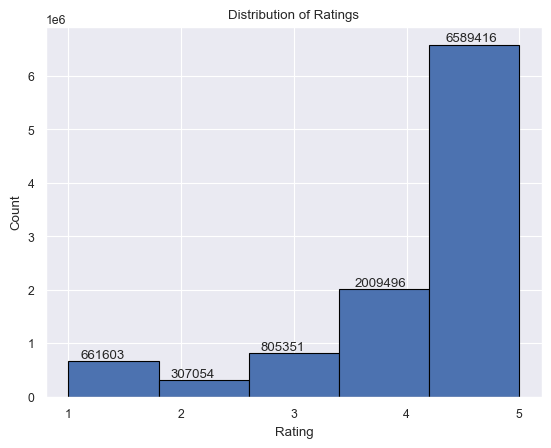

In [51]:
# Distribution of ratings: To understand the overall sentiment towards the businesses.

plt.hist(df['rating'], bins = 5, edgecolor = 'black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
# show exact counts
for i in range(1, 6):
    plt.text(i + 0.5 if i == 1 else i + 0.3 if i == 2 else i + 0.1 if i == 3 else i if i == 4 else i - 0.2, len(df[df['rating'] == i]), str(len(df[df['rating'] == i])), ha='right', va='bottom')
# change x ticks to read 1, 2, 3, 4, 5
plt.xticks(np.arange(1, 6, 1))

plt.show()


## Exploring review counts per local business

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

* Most businesses have 10-20 reviews, with the number of businesses decreasing at a decreasing rate as the number of reviews increases.
* The mean number of reviews is 20.5 with a standard deviation of 40.53.
* This suggests that a small number of businesses might be overrepresented in our dataset, especially the one outlying businesses with 1292 reviews.

In [52]:
column_names = df.columns.tolist()

print(column_names)

['user_id', 'name', 'time', 'rating', 'text', 'pics', 'resp', 'gmap_id']


Summary statistics for count of reviews per business:
count    91896.000000
mean       113.682935
std        297.993918
min          1.000000
25%          8.000000
50%         28.000000
75%         98.000000
max       9998.000000
Name: count, dtype: float64


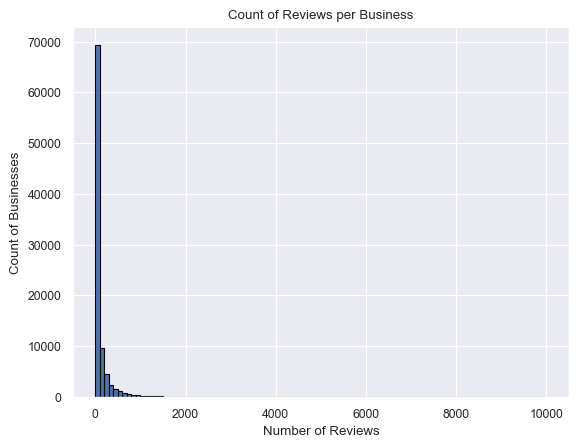

In [53]:
# Count of reviews per business - To see which businesses have been reviewed the most.

# describe the count of reviews per business
print("Summary statistics for count of reviews per business:")
print(df['gmap_id'].value_counts().describe())

df['gmap_id'].value_counts().plot(kind='hist', bins=100, edgecolor='black')
plt.title('Count of Reviews per Business')
plt.xlabel('Number of Reviews')
plt.ylabel('Count of Businesses')
plt.show()




## Exploring review lengths (in terms of number of characters)

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

* We see that review lengths are distributed similarly to business ratings, with a large number of reviews having under 100 characters, and with the number of reviews decreasing at a decreasing rate as the review length increases.
* The mean review length is 167.47, but with a large standard deviation of 273.39.

Summary statistics for review length:
count    1.044701e+07
mean     8.922128e+01
std      1.946101e+02
min      0.000000e+00
25%      0.000000e+00
50%      1.700000e+01
75%      9.600000e+01
max      9.053000e+03
Name: review_length, dtype: float64


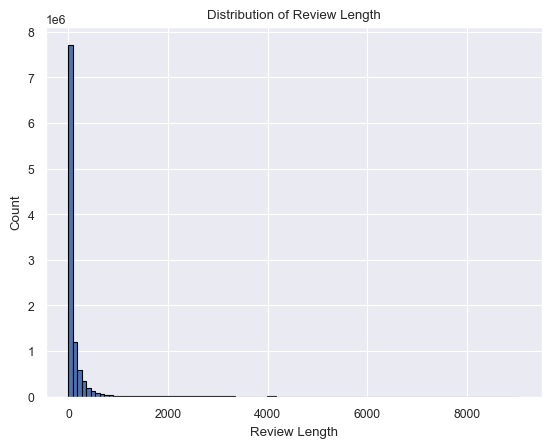

In [54]:
# Review length analysis: To see the distribution of the length of the review texts.

df['review_length'] = df['text'].apply(lambda x: len(x) if x is not None else 0)

# describe the review length
print("Summary statistics for review length:")
print(df['review_length'].describe())

plt.hist(df['review_length'], bins=100, edgecolor='black')
plt.title('Distribution of Review Length')
plt.xlabel('Review Length')
plt.ylabel('Count')
plt.show()



## Exploring correlation between review length and rating

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

* We analyzed the correlation between the length of the review text and the rating. The correlation coefficient is around -0.156, which suggests that there is only a weak negative correlation between the length of the review and the rating.
* This result is consistent with our intuition, as the length of a review does not necessarily indicate its quality or sentiment.
* However, perhaps some angrier customers might leave longer reviews, which could explain the slight negative correlation. 
* We also see that reviews with a rating of 3 have a relatively lower review length, which supports the overlying notion that people write more/longer reviews when they feel strongly about a restaurant. 

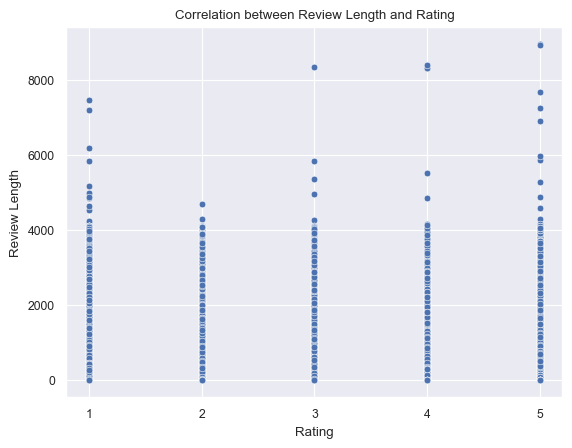

Correlation matrix:
                 rating  review_length
rating         1.000000      -0.184975
review_length -0.184975       1.000000


In [55]:
# Correlation between review length and rating: To see if there is a correlation between the length of the review and the rating given.

# plot the correlation between review length and rating
sns.scatterplot(x='rating', y='review_length', data=df)
plt.title('Correlation between Review Length and Rating')
plt.xlabel('Rating')
plt.ylabel('Review Length')
plt.xticks(np.arange(1, 6, 1))
plt.show()

correlation_matrix = df[['rating', 'review_length']].corr()
print("Correlation matrix:")
print(correlation_matrix)

## Number of unique authors

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

* We see that we have 77593 unique authors for our 100,000 reviews, which suggests that most authors have only left one review.
* This is confirmed by the mean number of reviews per author, which is 1.3 with a standard deviation of 0.88.
* In fact, we see through the summary statistics that over 75% of authors have only left 1 review. The most number of reviews left by one author is 62. 
* The shape of the distribution is once again similar to the previous two, with the number of authors decreasing at a decreasing rate as the number of reviews per author increases.

Number of unique authors:  2142256
Summary statistics for number of ratings per author:
count    2.142256e+06
mean     4.876638e+00
std      1.787627e+01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      8.277000e+03
Name: count, dtype: float64


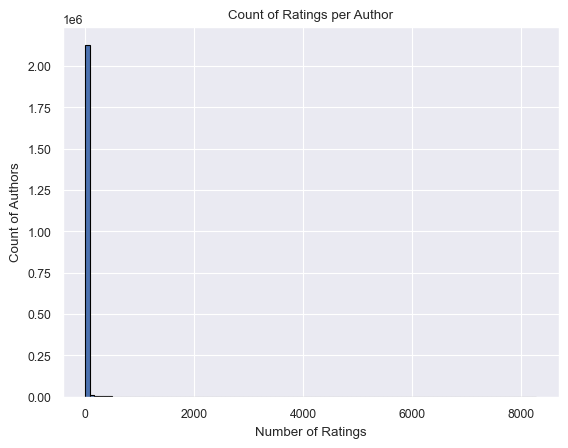

In [56]:
# How many unique authors?

print("Number of unique authors: ", df['name'].nunique())

# describe the count of ratings per author
print("Summary statistics for number of ratings per author:")
print(df['name'].value_counts().describe())

df['name'].value_counts().plot(kind='hist', bins=100, edgecolor='black')
plt.title('Count of Ratings per Author')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Authors')
plt.show()


## Simple sentiment analysis - Baseline Model

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

* We used the `TextBlob` library to perform a simple sentiment analysis on the review text.
* First, we dropped reviews with no text, as they would not provide any information for sentiment analysis.
* We then calculated the polarity of each review, which ranges from -1 (most negative) to 1 (most positive).
* Plotting a histogram and summary statistics, we see that most reviews are moderately positive with a mean polarity of 0.36 and a standard deviation of 0.31. This is consistent with our earlier observation that most ratings are positive (5 stars).
* The distribution is roughly bell-shaped, but with a density spike at 0 and a few more spikes above 0.5. 


/var/folders/_0/r3hbmwqx5xq4kbfgc3_xbss00000gn/T/ipykernel_92563/3980335880.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dropped['sentiment'] = df_dropped['text'].apply(lambda x: TextBlob(x).sentiment.polarity)


Summary statistics for sentiment:
count    5.796227e+06
mean     3.857944e-01
std      3.457900e-01
min     -1.000000e+00
25%      1.666667e-01
50%      4.000000e-01
75%      6.250000e-01
max      1.000000e+00
Name: sentiment, dtype: float64


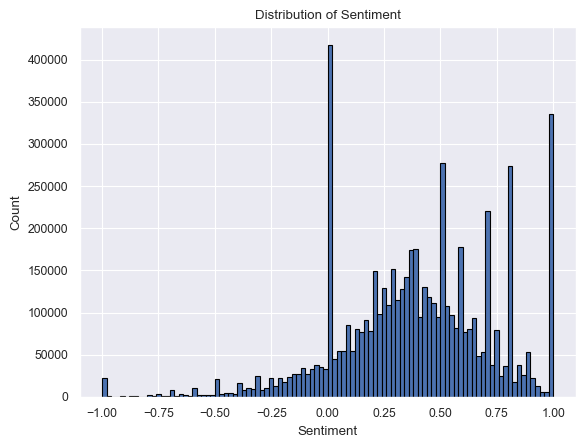

In [57]:
# Simple sentiment analysis on review text

# Add a column to the dataframe with the sentiment of the review
df_dropped = df.dropna(subset=['text'])
df_dropped['sentiment'] = df_dropped['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# print summary statistics
print("Summary statistics for sentiment:")
print(df_dropped['sentiment'].describe())

# plot the distribution of sentiment
plt.hist(df_dropped['sentiment'], bins=100, edgecolor='black')
plt.title('Distribution of Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

There is a moderate positive correlation between sentiment score and rating, with a correlation coefficient of 0.547. This suggests that reviews with higher ratings tend to have more positive sentiment scores, which is expected. This is a good result for our training data.

We were worried that meaningful sentiment might not be extracted from short reviews, but the correlation suggests that the sentiment analysis is capturing the sentiment of the reviews decently well. Yay!

In [58]:
# Find correlation between sentiment and rating
correlation_matrix = df_dropped[['rating', 'sentiment']].corr()
print("Correlation matrix:")
print(correlation_matrix)

Correlation matrix:
             rating  sentiment
rating     1.000000   0.547867
sentiment  0.547867   1.000000


## Summary of findings

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

* We see that the majority of ratings given by Google users are 5 out of 5. This aligns with the Google text review sentiment analysis, which found that the majority of the reviews had a postive sentiment.
* We also found that there is a weak correlation between the length of a text review and the rating given by the same Google user. However, it could be helpful to note that based on the visualization displayed above, the review length was longest for either 1 or 5 star reviews.
* In the sentiment analysis, we found that majority of the text reviews result in a sentiment score near 0, which suggests that many reviews are neutral. The second most common sentiment scores are those near 1, which suggests that there are also many (but not as many) reviews that are highly positive. 
* This summarizes the distributional features of our reviews in their length, sentiment and the related score.

## Revised Project Question

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

Creating a restaurant recommendation system based on textual reviews and and user-inputted prompts.


## Implementation Plan -- Draft Pipeline (MS3)

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

The structure of our problem is similar to that of designing a recommender system. We describe an initial approach that comes to mind:

**Recommender Model Pipeline:**
- **Training step** (preprocessing): Embed the reviews for all restaurants as vectors using sentence embeddings (BERT), or a combined approach using BERT and other feature engineered features from the restaurant information that we have. One approach is then to cluster restaurants in an unsupervised way in the feature space using an approach like KNN or t-SNE. Perhaps we can do this in an informed way, however.
- **Interaction step:** Then, we may take a user prompt of sentence length describing the restaurant type they are looking for, and use the fine-tuned BERT pipeline to get a vector representation of the prompt.
- **Matching step:** Then we can take the top recommendations as the closest three or so restaurants in the feature space to the prompt. We can incorporate additional heuristics in this matching step.
  

**Potential Issues:**
- Reviews and prompts are semantically different. We might encounter unexpected relationships between the restaurants closest in the feature space based on reviews and the inputted prompts.
- Perhaps a content-based filtering approach is more directly applicable as a pipeline (ref: https://developers.google.com/machine-learning/recommendation/content-based/basics).
- With an unsupervised approach like this, we have no systematized way to measure whether our recommending algorithm is doing a good job at matching prompts to restaurants. But this is the nature of trying a recommendation system rather than a predictive model. We do not have the resources to conduct proper A/B testing, which would otherwise be a canonical solution.
-  A collaborative filtering approach would be great, but is infeasible since we cannot recruit enough users. 

# 3. Pipeline and Baseline Model:

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

**Outline steps for a pipeline for the final model**

The goal of this project is to produce restaurant recommendations based on a user input of a [dish name], the model should output rankings of relevant restaurants based on sentiment analysis of text Google reviews that speak of the dish.
1. Data Preprocessing
    * We drop the duplicate reviews based on ‘user_id’ and ‘gmap_id’ to ensure unique reviews per user per restaurant.
    * We drop observations with NA values for ‘text’ and ‘rating’ because our model utilizes text reviews and restaurant ratings from users to create a weighted index (or ranking) of relevant restaurants. 
2. Retrieve input from user
    * We assume that the user will only put in a dish name (for now). 
3. Retrieve restaurants relevant to input
    * We assume that the user is querying for a restaurant that is currently open, so we filter out restaurants that are closed according to the time of query and the restaurant’s operating hours
    * We also go through each review for each restaurant and use RegEx to match the dish name to a review
    * All reviews within n miles-- Take coordinates from user through asking for location (API in Colab) and then take max distance n from user.
4. Conduct sentiment analysis among retrieved restaurants
5. Do a weighted index consisting of **sentiment + avg_rating**
6. Return the restaurants corresponding to the top 3 highest weighted indices
7. Prettify output for user using gmap_id


#### preprocessing:

In [71]:
# Load the data
with open('data/cleaned_data.csv', 'r') as f:
    data = f.readlines()

# Convert to dataframe
data_json_str = "[" + ','.join(data) + "]"
df = pd.read_csv(StringIO(data_json_str))

/var/folders/_0/r3hbmwqx5xq4kbfgc3_xbss00000gn/T/ipykernel_92563/3357004795.py:7: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(StringIO(data_json_str))


In [72]:
df = df_final

In [73]:
df.dtypes

Unnamed: 0          int64
user_id            object
rating            float64
text               object
gmap_id            object
name_y             object
description        object
latitude          float64
longitude         float64
category           object
avg_rating        float64
num_of_reviews    float64
price               int64
hours              object
Dining options     object
Popular for        object
Atmosphere         object
Crowd              object
dtype: object

In [74]:
### get 10000 restaurants dumb sample. Take pics out.

# Import the necessary libraries
# Set the random seed for reproducibility
np.random.seed(42)

# Group by 'name_y'
grouped = df.groupby('name_y')


# If you need to work with all entries for each 'gmap_id' and then select 1000 groups
## Option 1: Select the first 1000 unique restaurants
top_1000_restaurants = grouped.apply(lambda x: x.head(1)).sample(1000)

## Option 2: If you need to select based on the size of each group (e.g., most entries)
# This will sort groups by size and take the top 1000 groups
top_1000_restaurants = grouped.size().nlargest(500).index
selected_entries = df[df['name_y'].isin(top_1000_restaurants)]


## Option 3:
# Randomly sample 1000 unique restaurants
# Ensure you have unique restaurants first
unique_restaurants = df.drop_duplicates(subset='name_y')
n_0 = 100
if len(unique_restaurants) >= n_0:
    sampled_restaurants = unique_restaurants.sample(n=n_0, random_state=1)  # Use random_state for reproducibility
else:
    print("There are less than 1000 unique restaurants available.")
    sampled_restaurants = unique_restaurants  # Use all available if less than 1000

# Now, get all entries for these 1000 restaurants
selected_entries = df[df['name_y'].isin(sampled_restaurants['name_y'])]

# Print or inspect the result
display(selected_entries)

# we have 76k rows. This is workable.
df = selected_entries
# Preprocess to remove invalid coordinate restaurants
df = df[(df['latitude'] != 0) | (df['longitude'] != 0)]

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1039f5f10>>
Traceback (most recent call last):
  File "/Users/suahnam/micromamba/envs/cs109b/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
/var/folders/_0/r3hbmwqx5xq4kbfgc3_xbss00000gn/T/ipykernel_92563/3184828039.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_1000_restaurants = grouped.apply(lambda x: x.head(1)).sample(1000)


Unnamed: 0                user_id  rating  \
34             2459  108844622736166573009     3.0   
35             2460  117062297464306327220     5.0   
36             2461  105533956309966343472     3.0   
37             2462  106244992235769021950     5.0   
38             2463  113668226494137792817     4.0   
...             ...                    ...     ...   
1086941     2917143  103425837895654532086     5.0   
1086942     2917144  103224305129880405655     5.0   
1086943     2917145  107706800670185496492     5.0   
1086944     2917146  115779338616319484396     5.0   
1086945     2917147  113502913034959965995     4.0   

                                                      text  \
34       There pizza is decent, and you can get your pi...   
35       It's a pizza hut so don't expect gourmet. But ...   
36       Great pizza. Pretty expensive. Very limited si...   
37       I love pizza and a thing is better than all th...   
38       I good but cheese is two chesesey. I love 7 el...   
...                                                    ...   
1086941  (Translated by Google) Excellent place, especi...   
1086942  (Translated by Google) excellent food and hits...   
1086943  (Translated by Google) Great Huge sizes\n\n(Or...   
1086944  (Translated by Google) I loved it\n\n(Original...   
1086945  (Translated by Google) 930 EST?\n\n(Original)\...   

                                       gmap_id                  name_y  \
34        0x89e6c8bd73cbd4e9:0x280a110349082ae               Pizza Hut   
35        0x89e6c8bd73cbd4e9:0x280a110349082ae               Pizza Hut   
36        0x89e6c8bd73cbd4e9:0x280a110349082ae               Pizza Hut   
37        0x89e6c8bd73cbd4e9:0x280a110349082ae               Pizza Hut   
38        0x89e6c8bd73cbd4e9:0x280a110349082ae               Pizza Hut   
...                                        ...                     ...   
1086941  0x89e3ee8a1418cfd7:0x6a1fd79c02f5c203  Kimball Farm Lancaster   
1086942  0x89e3ee8a1418cfd7:0x6a1fd79c02f5c203  Kimball Farm Lancaster   
1086943  0x89e3ee8a1418cfd7:0x6a1fd79c02f5c203  Kimball Farm Lancaster   
1086944  0x89e3ee8a1418cfd7:0x6a1fd79c02f5c203  Kimball Farm Lancaster   
1086945  0x89e3ee8a1418cfd7:0x6a1fd79c02f5c203  Kimball Farm Lancaster   

                                               description   latitude  \
34       Family-friendly chain known for its made-to-or...  42.288582   
35       Family-friendly chain known for its made-to-or...  42.288582   
36       Family-friendly chain known for its made-to-or...  42.288582   
37       Family-friendly chain known for its made-to-or...  42.288582   
38       Family-friendly chain known for its made-to-or...  42.288582   
...                                                    ...        ...   
1086941                                                NaN  42.506870   
1086942                                                NaN  42.506870   
1086943                                                NaN  42.506870   
1086944                                                NaN  42.506870   
1086945                                                NaN  42.506870   

         longitude                                           category  \
34      -72.407528  ['Pizza restaurant', 'Chicken wings restaurant...   
35      -72.407528  ['Pizza restaurant', 'Chicken wings restaurant...   
36      -72.407528  ['Pizza restaurant', 'Chicken wings restaurant...   
37      -72.407528  ['Pizza restaurant', 'Chicken wings restaurant...   
38      -72.407528  ['Pizza restaurant', 'Chicken wings restaurant...   
...            ...                                                ...   
1086941 -71.691854  ['Ice cream shop', 'Dessert shop', 'Gift shop'...   
1086942 -71.691854  ['Ice cream shop', 'Dessert shop', 'Gift shop'...   
1086943 -71.691854  ['Ice cream shop', 'Dessert shop', 'Gift shop'...   
1086944 -71.691854  ['Ice cream shop', 'Dessert shop', 'Gift shop'...   
1086945 -71.691854  ['Ice cream shop', 'Desser

### Stage 1: filter by basic criteria

In [64]:
#!pip install geocoder
#!pip install geopy

In [77]:
import geocoder
import pandas as pd
from geopy.distance import geodesic

# Get user coordinates
def get_user_coordinates():
    g = geocoder.ip('me')
    if g.latlng:
        return g.latlng
    else:
        return None

coordinates = get_user_coordinates()
if coordinates:
    user_latitude, user_longitude = coordinates
    print(f"User's coordinates: Latitude={user_latitude}, Longitude={user_longitude}")
else:
    print("Unable to retrieve user's coordinates.")
    # Define default values or handle lack of coordinates appropriately
    # user_latitude, user_longitude = default_latitude, default_longitude


# Function to calculate distance using geopy
def calculate_distance(row, user_lat, user_lon):
    user_location = (user_lat, user_lon)
    business_location = (row['latitude'], row['longitude'])
    return geodesic(user_location, business_location).miles

# Apply the distance function
df['distance'] = df.apply(lambda row: calculate_distance(row, user_latitude, user_longitude), axis=1)
df_filtered = df[df['distance'] <= 10]  # Filter data within 10 miles

# Print the filtered DataFrame
print(df_filtered)


User's coordinates: Latitude=42.3751, Longitude=-71.1056
         Unnamed: 0                user_id  rating  \
476            6466  106034892868097046105     2.0   
477            6467  106957488567743812459     5.0   
478            6468  116755702744807339143     1.0   
479            6469  103769868881625913060     5.0   
480            6470  102143475769301030095     1.0   
...             ...                    ...     ...   
1067163     2863925  106033695451915144625     3.0   
1067164     2863926  107218750720434167138     4.0   
1067165     2863927  103986765889026374321     3.0   
1067166     2863928  118344359369261300532     5.0   
1067167     2863929  101064252226452023224     3.0   

                                                      text  \
476      We got 2 subs.  Bred was old and crumbly on bo...   
477      I love this place good food employee good peop...   
478      Rude people selling 4" subs for 6" and arguing...   
479      This is my go to sub shop for quick a

Only 5k reviews left!

Issue to be adressed in final model: for 1.6M reviews, this search-method is intractable.

In [78]:
df_filtered

Unnamed: 0                user_id  rating  \
476            6466  106034892868097046105     2.0   
477            6467  106957488567743812459     5.0   
478            6468  116755702744807339143     1.0   
479            6469  103769868881625913060     5.0   
480            6470  102143475769301030095     1.0   
...             ...                    ...     ...   
1067163     2863925  106033695451915144625     3.0   
1067164     2863926  107218750720434167138     4.0   
1067165     2863927  103986765889026374321     3.0   
1067166     2863928  118344359369261300532     5.0   
1067167     2863929  101064252226452023224     3.0   

                                                      text  \
476      We got 2 subs.  Bred was old and crumbly on bo...   
477      I love this place good food employee good peop...   
478      Rude people selling 4" subs for 6" and arguing...   
479      This is my go to sub shop for quick and yummy ...   
480      Horrible service. The worker was so late to wo...   
...                                                    ...   
1067163  (Translated by Google) A local restaurant with...   
1067164  (Translated by Google) Good meal, blueberry be...   
1067165  (Translated by Google) Suitable for watching s...   
1067166  (Translated by Google) Good bar. Delicious bee...   
1067167  (Translated by Google) Nachos or large\n\n(Ori...   

                                       gmap_id                  name_y  \
476      0x89e3713f5219d103:0xb2d6e939f396c374                  Subway   
477      0x89e3713f5219d103:0xb2d6e939f396c374                  Subway   
478      0x89e3713f5219d103:0xb2d6e939f396c374                  Subway   
479      0x89e3713f5219d103:0xb2d6e939f396c374                  Subway   
480      0x89e3713f5219d103:0xb2d6e939f396c374                  Subway   
...                                        ...                     ...   
1067163  0x89e37086f36e4f35:0xb7523b6f58d3f9a1  Warehouse Bar & Grille   
1067164  0x89e37086f36e4f35:0xb7523b6f58d3f9a1  Warehouse Bar & Grille   
1067165  0x89e37086f36e4f35:0xb7523b6f58d3f9a1  Warehouse Bar & Grille   
1067166  0x89e37086f36e4f35:0xb7523b6f58d3f9a1  Warehouse Bar & Grille   
1067167  0x89e37086f36e4f35:0xb7523b6f58d3f9a1  Warehouse Bar & Grille   

                                               description   latitude  \
476      Casual counter-serve chain for build-your-own ...  42.414077   
477      Casual counter-serve chain for build-your-own ...  42.414077   
478      Casual counter-serve chain for build-your-own ...  42.414077   
479      Casual counter-serve chain for build-your-own ...  42.414077   
480      Casual counter-serve chain for build-your-own ...  42.414077   
...                                                    ...        ...   
1067163  Stylish gastropub serving New American fare in...  42.358465   
1067164  Stylish gastropub serving New American fare in...  42.358465   
1067165  Stylish gastropub serving New American fare in...  42.358465   
1067166  Stylish gastropub serving New American fare in...  42.358465   
1067167  Stylish gastropub serving New American fare in...  42.358465   

         longitude                                           category  \
476     -71.078086  ['Sandwich shop', 'Caterer', 'Fast food restau...   
477     -71.078086  ['Sandwich shop', 'Caterer', 'Fast food restau...   
478     -71.078086  ['Sandwich shop', 'Caterer', 'Fast food restau...   
479     -71.078086  ['Sandwich shop', 'Caterer', 'Fast food restau...   
480     -71.078086  ['Sandwich shop', 'Caterer', 'Fast food restau...   
...            ...                                                ...   
1067163 -71.054002  ['Restaurant', 'American restaurant', 'Bar', '...   
1067164 -71.054002  ['Restaurant', 'American restaurant', 'Bar', '...   
1067165 -71.054002  ['Restaurant', 'American restaurant', 'Bar', '...   
1067166 -71.054002  ['Restaurant', 'American restaurant', 'Bar', '...   
1067167 -71.054002  ['Restaurant', 'American r

In [79]:
# inspect hours column
# df reset index
df.reset_index(drop=True, inplace=True)
df.head(10)
# drop column "Unnamed: 0"
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head(10)

user_id  rating  \
0  108844622736166573009     3.0   
1  117062297464306327220     5.0   
2  105533956309966343472     3.0   
3  106244992235769021950     5.0   
4  113668226494137792817     4.0   
5  103465203547636671181     4.0   
6  117180855260807789293     4.0   
7  101436804430068841350     1.0   
8  109790671398818529335     1.0   
9  110747232893159130943     5.0   

                                                text  \
0  There pizza is decent, and you can get your pi...   
1  It's a pizza hut so don't expect gourmet. But ...   
2  Great pizza. Pretty expensive. Very limited si...   
3  I love pizza and a thing is better than all th...   
4  I good but cheese is two chesesey. I love 7 el...   
5  Quick service good pizza and boneless garlic P...   
6  Pretty good tasting pizza, crust could use a  ...   
7  Terrible service. Communication issues, don't ...   
8       IT'S THE ONLY PLACE I THINK A WASTE OF TIME!   
9            Got a free pizza with my online points.   

                                gmap_id     name_y  \
0  0x89e6c8bd73cbd4e9:0x280a110349082ae  Pizza Hut   
1  0x89e6c8bd73cbd4e9:0x280a110349082ae  Pizza Hut   
2  0x89e6c8bd73cbd4e9:0x280a110349082ae  Pizza Hut   
3  0x89e6c8bd73cbd4e9:0x280a110349082ae  Pizza Hut   
4  0x89e6c8bd73cbd4e9:0x280a110349082ae  Pizza Hut   
5  0x89e6c8bd73cbd4e9:0x280a110349082ae  Pizza Hut   
6  0x89e6c8bd73cbd4e9:0x280a110349082ae  Pizza Hut   
7  0x89e6c8bd73cbd4e9:0x280a110349082ae  Pizza Hut   
8  0x89e6c8bd73cbd4e9:0x280a110349082ae  Pizza Hut   
9  0x89e6c8bd73cbd4e9:0x280a110349082ae  Pizza Hut   

                                         description   latitude  longitude  \
0  Family-friendly chain known for its made-to-or...  42.288582 -72.407528   
1  Family-friendly chain known for its made-to-or...  42.288582 -72.407528   
2  Family-friendly chain known for its made-to-or...  42.288582 -72.407528   
3  Family-friendly chain known for its made-to-or...  42.288582 -72.407528   
4  Family-friendly chain known for its made-to-or...  42.288582 -72.407528   
5  Family-friendly chain known for its made-to-or...  42.288582 -72.407528   
6  Family-friendly chain known for its made-to-or...  42.288582 -72.407528   
7  Family-friendly chain known for its made-to-or...  42.288582 -72.407528   
8  Family-friendly chain known for its made-to-or...  42.288582 -72.407528   
9  Family-friendly chain known for its made-to-or...  42.288582 -72.407528   

                                            category  avg_rating  \
0  ['Pizza restaurant', 'Chicken wings restaurant...         3.6   
1  ['Pizza restaurant', 'Chicken wings restaurant...         3.6   
2  ['Pizza restaurant', 'Chicken wings restaurant...         3.6   
3  ['Pizza restaurant', 'Chicken wings restaurant...         3.6   
4  ['Pizza restaurant', 'Chicken wings restaurant...         3.6   
5  ['Pizza restaurant', 'Chicken wings restaurant...         3.6   
6  ['Pizza restaurant', 'Chicken wings restaurant...         3.6   
7  ['Pizza restaurant', 'Chicken wings restaurant...         3.6   
8  ['Pizza restaurant', 'Chicken wings restaurant...         3.6   
9  ['Pizza restaurant', 'Chicken wings restaurant...         3.6   

   num_of_reviews  price hours       Dining options  \
0            33.0      1   NaN  ['Lunch', 'Dinner']   
1            33.0      1   NaN  ['Lunch', 'Dinner']   
2            33.0      1   NaN  ['Lunch', 'Dinner']   
3            33.0      1   NaN  ['Lunch', 'Dinner']   
4            33.0      1   NaN  ['Lunch', 'Dinner']   
5            33.0      1   NaN  ['Lunch', 'Dinner']   
6            33.0      1   NaN  ['Lunch', 'Dinner']   
7            33.0      1   NaN  ['Lunch', 'Dinner']   
8            33.0      1   NaN  ['Lunch', 'Dinner']   
9            33.0      1   NaN  ['Lunch', 'Dinner']   

                          Popular for  Atmosphere                 Crowd  \
0  ['Lunch', 'Dinner', 'Solo dining']  ['Casual']  ['College students']   
1  ['Lunch', 'Dinner', 'Solo dining']  ['Cas

In [80]:
#!pip install python-dateutil

In [81]:
### filter by opening hour -- DHATI

import pandas as pd
from datetime import datetime
import pytz 
from dateutil import parser



def is_open(current_time, hours_str):
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    current_day = days[current_time.weekday()]
    for day_segment in eval(hours_str):
        day, hours = day_segment[0], day_segment[1]
        print(day, hours)
        print(hours.split('–'))
        if day == current_day and hours != 'Closed':
            open_time, close_time = hours.split('–')
            open_time = parser.parse(open_time).time()
            close_time = parser.parse(close_time).time()
            if current_time.time() >= open_time and current_time.time() <= close_time:
                return True
    return False

user_timezone = pytz.timezone('America/New_York') 
current_time = datetime.now(user_timezone)

# Apply the function to filter DataFrame
df['is_open'] = df['hours'].apply(lambda x: is_open(current_time, x) if pd.notna(x) else False)


df_open_now = df[df['is_open']]


df_open_now

Monday 7AM–9PM
['7AM', '9PM']
Tuesday 7AM–9PM
['7AM', '9PM']
Wednesday 7AM–9PM
['7AM', '9PM']
Monday 7AM–9PM
['7AM', '9PM']
Tuesday 7AM–9PM
['7AM', '9PM']
Wednesday 7AM–9PM
['7AM', '9PM']
Monday 7AM–9PM
['7AM', '9PM']
Tuesday 7AM–9PM
['7AM', '9PM']
Wednesday 7AM–9PM
['7AM', '9PM']
Monday 7AM–9PM
['7AM', '9PM']
Tuesday 7AM–9PM
['7AM', '9PM']
Wednesday 7AM–9PM
['7AM', '9PM']
Monday 7AM–9PM
['7AM', '9PM']
Tuesday 7AM–9PM
['7AM', '9PM']
Wednesday 7AM–9PM
['7AM', '9PM']
Monday 7AM–9PM
['7AM', '9PM']
Tuesday 7AM–9PM
['7AM', '9PM']
Wednesday 7AM–9PM
['7AM', '9PM']
Monday 7AM–9PM
['7AM', '9PM']
Tuesday 7AM–9PM
['7AM', '9PM']
Wednesday 7AM–9PM
['7AM', '9PM']
Monday 7AM–9PM
['7AM', '9PM']
Tuesday 7AM–9PM
['7AM', '9PM']
Wednesday 7AM–9PM
['7AM', '9PM']
Monday 7AM–9PM
['7AM', '9PM']
Tuesday 7AM–9PM
['7AM', '9PM']
Wednesday 7AM–9PM
['7AM', '9PM']
Monday 7AM–9PM
['7AM', '9PM']
Tuesday 7AM–9PM
['7AM', '9PM']
Wednesday 7AM–9PM
['7AM', '9PM']
Monday 9AM–8:30PM
['9AM', '8:30PM']
Tuesday 9AM–8:30PM
['9AM

user_id  rating  \
15     108120697712758339183     5.0   
16     115997866388003961656     1.0   
17     108377993851599519925     1.0   
18     100098084397739288904     1.0   
19     117519047195383538729     1.0   
...                      ...     ...   
23574  103425837895654532086     5.0   
23575  103224305129880405655     5.0   
23576  107706800670185496492     5.0   
23577  115779338616319484396     5.0   
23578  113502913034959965995     4.0   

                                                    text  \
15     I have never seen anybody so attentive to my o...   
16     $10.60 for a 6 inch sub meal.  Cheese ham pepp...   
17     I got sick on their tunafish. The cold meat is...   
18     You can tell they feel cleaning table tops is ...   
19     Awful service I've had in subway stores ever. ...   
...                                                  ...   
23574  (Translated by Google) Excellent place, especi...   
23575  (Translated by Google) excellent food and hits...   
23576  (Translated by Google) Great Huge sizes\n\n(Or...   
23577  (Translated by Google) I loved it\n\n(Original...   
23578  (Translated by Google) 930 EST?\n\n(Original)\...   

                                     gmap_id                  name_y  \
15     0x89e3ef87850bfd23:0x8b6eb0fbeb9a2185                  Subway   
16     0x89e3ef87850bfd23:0x8b6eb0fbeb9a2185                  Subway   
17     0x89e3ef87850bfd23:0x8b6eb0fbeb9a2185                  Subway   
18     0x89e3ef87850bfd23:0x8b6eb0fbeb9a2185                  Subway   
19     0x89e3ef87850bfd23:0x8b6eb0fbeb9a2185                  Subway   
...                                      ...                     ...   
23574  0x89e3ee8a1418cfd7:0x6a1fd79c02f5c203  Kimball Farm Lancaster   
23575  0x89e3ee8a1418cfd7:0x6a1fd79c02f5c203  Kimball Farm Lancaster   
23576  0x89e3ee8a1418cfd7:0x6a1fd79c02f5c203  Kimball Farm Lancaster   
23577  0x89e3ee8a1418cfd7:0x6a1fd79c02f5c203  Kimball Farm Lancaster   
23578  0x89e3ee8a1418cfd7:0x6a1fd79c02f5c203  Kimball Farm Lancaster   

                                             description   latitude  \
15     Casual counter-serve chain for build-your-own ...  42.493727   
16     Casual counter-serve chain for build-your-own ...  42.493727   
17     Casual counter-serve chain for build-your-own ...  42.493727   
18     Casual counter-serve chain for build-your-own ...  42.493727   
19     Casual counter-serve chain for build-your-own ...  42.493727   
...                                                  ...        ...   
23574                                                NaN  42.506870   
23575                                                NaN  42.506870   
23576                                                NaN  42.506870   
23577                                                NaN  42.506870   
23578                                                NaN  42.506870   

       longitude                                           category  \
15    -71.726781  ['Sandwich shop', 'Caterer', 'Fast food restau...   
16    -71.726781  ['Sandwich shop', 'Caterer', 'Fast food restau...   
17    -71.726781  ['Sandwich shop', 'Caterer', 'Fast food restau...   
18    -71.726781  ['Sandwich shop', 'Caterer', 'Fast food restau...   
19    -71.726781  ['Sandwich shop', 'Caterer', 'Fast food restau...   
...          ...                                                ...   
23574 -71.691854  ['Ice cream shop', 'Dessert shop', 'Gift shop'...   
23575 -71.691854  ['Ice cream shop', 'Dessert shop', 'Gift shop'...   
23576 -71.691854  ['Ice cream shop', 'Dessert shop', 'Gift shop'...   
23577 -71.691854  ['Ice cream shop', 'Dessert shop', 'Gift shop'...   
23578 -71.691854  ['Ice cream shop', 'Dessert shop', 'Gift shop'...   

       avg_rating  num_of_reviews  price  \
15            3.0            16.0      1   
16            3.0            16.0      1   
17            3.0            16.0      1   
18            3.0            16.0      1   
19            3.0           

In [82]:
### lookup dish: DHATI, JANICE

# get dish from user as a prompt

import pandas as pd
import re

# Function to create a regex pattern for the dish to handle variations
def create_dish_pattern(dish_name):
    words = dish_name.split()
    if len(words) > 1:
        # Create patterns to match both possible word orders
        pattern1 = r'\b' + r'\b.*\b'.join(map(re.escape, words)) + r'\b'
        pattern2 = r'\b' + r'\b.*\b'.join(map(re.escape, reversed(words))) + r'\b'
        return re.compile(pattern1 + '|' + pattern2, re.IGNORECASE)
    else:
        return re.compile(r'\b' + re.escape(dish_name) + r'\b', re.IGNORECASE)

# Function to find reviews that mention the dish using the regex pattern
def find_dish_reviews(df, pattern):
    matches = df['text'].str.contains(pattern, na=False)
    return df[matches]

# Get dish name from user
dish_name = input("Enter the name of the dish you are looking for: ")
pattern = create_dish_pattern(dish_name)

# Find reviews mentioning the dish
dish_reviews = find_dish_reviews(df, pattern)


print(dish_reviews[['name_y', 'text']])

# go restaurant by restaurant, then dish by dish, and look all reviews that mention prompt (my best guess is use regex, but think intelligently. pasta alfredo vs alfredo pasta)

                     name_y                                               text
1080             Yard House  My party waited approximately 1 hour; or more ...
1100             Yard House  Delicious food! My husband and I loved everyth...
1129             Yard House  For a chain restaurant, this place is awesome!...
1604   J & J House of Pizza                     Good pizza, good pasta dinner!
1857        The Lobster Pot  Start off with their homemade signature Bloody...
...                     ...                                                ...
22080           Dino's Cafe  Dino's is a go to spot in my neighborhood. The...
22089           Dino's Cafe  I’ve been to Dino’s a handful of times now and...
22091           Dino's Cafe  This place serves decent food, but not amazing...
22120           Dino's Cafe              Great staff and great pasta the best!
22140           Dino's Cafe  I love everything! The subs are huge and there...

[110 rows x 2 columns]


### Stage 2: rank by sentiment for the dish

In [83]:
from textblob import TextBlob

# Do a general, simple sentiment analysis on the reviews first
def analyze_general_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity, analysis.sentiment.subjectivity


In [84]:
df['sentiment_polarity'], df['sentiment_subjectivity'] = zip(*df['text'].apply(analyze_general_sentiment))

In [85]:
df[['sentiment_polarity', 'sentiment_subjectivity']].describe()

sentiment_polarity  sentiment_subjectivity
count        23579.000000            23579.000000
mean             0.400312                0.598220
std              0.373778                0.230510
min             -1.000000                0.000000
25%              0.160000                0.500000
50%              0.433333                0.604167
75%              0.690118                0.750000
max              1.000000                1.000000

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

**Sentiment Polarity**

* Definition: Sentiment polarity is a floating-point number ranging between -1.0 and 1.0. This score represents the emotional leaning of the text, where -1.0 signifies extreme negativity, 1.0 signifies extreme positivity, and 0 signifies neutrality.
* Interpretation:
    * Negative polarity (less than 0): Indicates negative sentiments in the text.
    * Positive polarity (greater than 0): Indicates positive sentiments in the text.
    * Zero polarity: Indicates neutral sentiments in the text.

**Sentiment Subjectivity**

* Definition: Sentiment subjectivity ranges between 0 and 1. This score reflects how much of the text is based on personal opinions, emotions, or judgments rather than factual information.
* Interpretation:
    * Subjectivity close to 0: Texts are more objective, likely based on factual information.
    * Subjectivity close to 1: Texts are more subjective, heavily influenced by personal feelings or opinions.

**Interpretation of our data**

* The mean polarity of 0.4289 suggests that, on average, the reviews lean towards being more positive.
* The minimum value at -1.0 and maximum at 1.0 indicate that there are both extremely negative and extremely positive reviews in the dataset.
* The mean subjectivity of 0.6135 indicates that the reviews, on average, are somewhat subjective and likely to contain personal opinions rather than solely factual descriptions.
* The standard deviation for subjectivity (0.2214) suggests there's some variation in how subjective the reviews are, with some being more fact-based and others more opinion-oriented.



In [86]:
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

def get_weighted_index(row):
    sentiment = get_sentiment(row['text'])
    avg_rating = row['rating']
    return 0.8 * sentiment + 0.2 * avg_rating

def get_top_restaurants(df, n):
    df['weighted_index'] = df.apply(get_weighted_index, axis=1)
    return df.sort_values('weighted_index', ascending=False).head(n)

get_top_restaurants(df, 10)


user_id  rating  \
15233  116550181753595206491     5.0   
9290   105280070722750412123     5.0   
9312   104907360577019604958     5.0   
9311   109098715133225507941     5.0   
9303   109927440479034227576     5.0   
9300   116024439103015276039     5.0   
9299   109010718777968189454     5.0   
2111   102677061116620698582     5.0   
9289   103504450812088449568     5.0   
18299  111271159499657261136     5.0   

                                                    text  \
15233  Food is delicious and leaves nothing to be des...   
9290           They have the best salmon & margaritas!!!   
9312          The best Dominican food in Boston, period!   
9311                                           Excellent   
9303                           Food is always delicious!   
9300                                     Delicious food.   
9299                       Best dominican food in town!!   
2111                          Excellent food no waiting.   
9289                                           Excellent   
18299                                        Very good !   

                                     gmap_id                name_y  \
15233  0x89e3f86a984bd995:0x178f7b46cca8a219  Oli's Italian Eatery   
9290   0x89e37a34eb8e0b2d:0x5dfe09ff97d850ca   Merengue Restaurant   
9312   0x89e37a34eb8e0b2d:0x5dfe09ff97d850ca   Merengue Restaurant   
9311   0x89e37a34eb8e0b2d:0x5dfe09ff97d850ca   Merengue Restaurant   
9303   0x89e37a34eb8e0b2d:0x5dfe09ff97d850ca   Merengue Restaurant   
9300   0x89e37a34eb8e0b2d:0x5dfe09ff97d850ca   Merengue Restaurant   
9299   0x89e37a34eb8e0b2d:0x5dfe09ff97d850ca   Merengue Restaurant   
2111   0x89fca77c7737d4a1:0x9dbcae4ddbd4bd68       The Lobster Pot   
9289   0x89e37a34eb8e0b2d:0x5dfe09ff97d850ca   Merengue Restaurant   
18299  0x89e37e954ea3be21:0x78e97a851d0a1fcd             Pizza Hut   

                                             description   latitude  \
15233  Family-friendly Italian kitchen preparing chic...  42.340777   
9290   Dominican fare, weekend live music & bright, a...  42.319190   
9312   Dominican fare, weekend live music & bright, a...  42.319190   
9311   Dominican fare, weekend live music & bright, a...  42.319190   
9303   Dominican fare, weekend live music & bright, a...  42.319190   
9300   Dominican fare, weekend live music & bright, a...  42.319190   
9299   Dominican fare, weekend live music & bright, a...  42.319190   
2111   Laid-back landmark draws crowds with seafood c...  42.052002   
9289   Dominican fare, weekend live music & bright, a...  42.319190   
18299  Family-friendly chain known for its made-to-or...  42.266978   

       longitude                                           category  \
15233 -71.788016  ['Italian restaurant', 'Pizza restaurant', 'Pi...   
9290  -71.077559  ['Dominican restaurant', 'Caribbean restaurant...   
9312  -71.077559  ['Dominican restaurant', 'Caribbean restaurant...   
9311  -71.077559  ['Dominican restaurant', 'Caribbean restaurant...   
9303  -71.077559  ['Dominican restaurant', 'Caribbean restaurant...   
9300  -71.077559  ['Dominican restaurant', 'Caribbean restaurant...   
9299  -71.077559  ['Dominican restaurant', 'Caribbean restaurant...   
2111  -70.185352                      ['Seafood restaurant', 'Bar']   
9289  -71.077559  ['Dominican restaurant', 'Caribbean restaurant...   
18299 -71.120419  ['Pizza restaurant', 'Chicken wings restaurant...   

       avg_rating  ...                                              hours  \
15233         4.4  ...  [['Friday', '11AM–9PM'], ['Saturday', '11AM–9P...   
9290          4.1  ...  [['Monday', '10AM–8:50PM'], ['Tuesday', '10AM–...   
9312          4.1  ...  [['Monday', '10AM–8:50PM'], ['Tuesday', '10AM–...   
9311          4.1  ...  [['Monday', '10AM–8:50PM'], ['Tuesday', '10AM–...   
9303          4.1  ...  [['Monday', '10AM–8:50PM'], ['Tuesday', '10AM–...   
9300          4.1  ...  [['Monday', '10AM–8:50PM'], ['Tuesday', '10AM–...   
9299          4.1  ...  [['Monday', '10AM–8:5

#### Combine all the above functions into a pipeline

In [87]:
def get_recommendations(df, dish_name, n):
    df_open_now = df[df['is_open']]
    pattern = create_dish_pattern(dish_name)
    dish_reviews = find_dish_reviews(df_open_now, pattern)
    return get_top_restaurants(dish_reviews, n)

dish_name = "pasta"
n = 10

get_recommendations(df, dish_name, n)


/var/folders/_0/r3hbmwqx5xq4kbfgc3_xbss00000gn/T/ipykernel_92563/888737167.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weighted_index'] = df.apply(get_weighted_index, axis=1)


user_id  rating  \
5834   110159688399291244133     5.0   
12072  116176764326329492680     5.0   
8554   115459903312188149992     5.0   
14889  113842460715616111154     5.0   
7814   115598992184894327658     5.0   
15518  110875319107114027491     5.0   
22120  112812483882424131852     5.0   
7818   116004532989056286857     5.0   
7774   103226230045082471245     5.0   
15045  104544587126085276026     5.0   

                                                    text  \
5834       The best for everything,  Pasta, Subs, Pizza.   
12072            Awesome pizzas n subs and pasta dinners   
8554   Great food and great service! The pasta marina...   
14889  Very delicious food! There is a great variety ...   
7814   Food was delicious and speedy, any pasta dish ...   
15518     Pasta was amazing, pizza delicious. Loved it!!   
22120              Great staff and great pasta the best!   
7818   Veal parm was incredible and the homemade past...   
7774   Great choice of pasta, nice location the food ...   
15045                  Great taco salad and pesto pasta.   

                                     gmap_id                         name_y  \
5834    0x89e37624f56532dd:0x363879afc3cafdd     Northender Italian Kitchen   
12072  0x89e4fc0e05183271:0xbe6b4914c6d6893f                   Nick's Pizza   
8554    0x89fb39b4b2b59b4f:0xa2cc6f63f027620  Royal II Restaurant and Grill   
14889  0x89e3707f15a7323f:0x6866e9c35d4a8b80     by CHLOE. - Boston Seaport   
7814   0x89e370899e4d79f3:0x4aa6242da91ac763                       La Summa   
15518  0x89e6e0b78d0de209:0x52d7e38e39102347                      Pizza Hut   
22120  0x89e370894b0055e1:0x2c4aebfe36f9f0df                    Dino's Cafe   
7818   0x89e370899e4d79f3:0x4aa6242da91ac763                       La Summa   
7774   0x89e370899e4d79f3:0x4aa6242da91ac763                       La Summa   
15045  0x89e3707f15a7323f:0x6866e9c35d4a8b80     by CHLOE. - Boston Seaport   

                                             description   latitude  \
5834                                                 NaN  42.424501   
12072                                                NaN  41.657709   
8554   Comfortable diner & bar serving up classic Med...  41.708130   
14889  Popular NYC-founded chain for vegan dishes, sw...  42.351118   
7814   Humble find for homemade pastas, chicken Parme...  42.364615   
15518  Family-friendly chain known for its made-to-or...  42.132381   
22120  Italian standbys & hearty subs served for dine...  42.365057   
7818   Humble find for homemade pastas, chicken Parme...  42.364615   
7774   Humble find for homemade pastas, chicken Parme...  42.364615   
15045  Popular NYC-founded chain for vegan dishes, sw...  42.351118   

       longitude                                           category  \
5834  -71.183492  ['Restaurant', 'Caterer', 'Italian restaurant'...   
12072 -71.079975  ['Pizza restaurant', 'Greek restaurant', 'Pizz...   
8554  -70.211778  ['Mediterranean restaurant', 'American restaur...   
14889 -71.045128  ['Vegan restaurant', 'Hamburger restaurant', '...   
7814  -71.052551               ['Italian restaurant', 'Restaurant']   
15518 -72.626388  ['Pizza delivery', 'Chicken wings restaurant',...   
22120 -71.055358                             ['Italian restaurant']   
7818  -71.052551               ['Italian restaurant', 'Restaurant']   
7774  -71.052551               ['Italian restaurant', 'Restaurant']   
15045 -71.045128  ['Vegan restaurant', 'Hamburger restaurant', '...   

       avg_rating  ...                                              hours  \
5834          4.6  ...  [['Sunday', '11AM–9PM'], ['Monday', '11AM–9PM'...   
12072         4.6  ...  [['Thursday', '9AM–9PM'], ['Friday', '9AM–9PM'...   
8554          4.7  ...  [['Tuesday', '11:30AM–9PM'], ['Wednesday', '11...   
14889         4.3  ...  [['Friday', '11AM–8PM'], ['Saturday', '11AM–8P...   
7814          4.5  ...  [['Thursday', '4–9:30PM'], ['Friday', '4–10PM'...   
15518         4.0  ... 

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

**Results Interpretation and Analysis**

* Analyze baseline model's performance
    * Based on the df above, we see that the top two weighted indices are the same at 1.8. This suggests that we can amend the current model to make more distinctions between restaurants, whether it be through addition to the sentiment analysis or incorporating other variables to the recommending process. 
    * However, we see that the restaurants that are recommended have highly positive reviews, are currently open (at the time that the code was run), and serve the dish that the user input (in this case, pasta). 
    * Since this the output is a recommendation, we are not sure how to provide metrics to show the accuracy, as recommendations are mostly subjective (for example, I can agree with a recommendation, but Ethan might not). Help on this would be appreciated!
    
    
* Assess strengths and weaknesses of the model
    * RegEx is not the best way to search for keywords in reviews because there is variation in how people refer to different dishes. For example, 'chicken alfredo' and 'alfredo pasta' can be referring to the same thing.
    * We used a simple sentiment score, but we could be doing more detailed analysis on the review text. 
    * The model is very basic right now, and for the next iterations, we want to make the recommendations more robust by improving the keyword matching process (instead of a simple RegEx string) and prettifying the results so that it is easier for the user to process. 
    * The model however has its strengths as it is achieving what we want it to do at this point: it filters for currently open restaurants, ranks the restaurants to a degree, and only includes restaurants that serve the dish that the user inputs. 


<div style="background-color:#3F7FBF; color:white; padding:10px"> 

**Goals and Responsibilities for members**

* Dries and Dhati will be working on the full pipeline, especially the data collection. We should try to work with more recent data than the 2021 google maps dataset. We have to find smart ways to take representative samples to train a potentially more complicated sentiment model on.

* Susannah will be working on improving the sentiment analysis stage of the pipeline. Perhaps using RAGs or other language model techniques, we can hone in on the sentiment relating to the review 

* Ethan and Janice will be improving on the Retrieval part of the pipeline. RegEx is somewhat arcane for this task as we need to be able to retrieve slightly different synonyms for the dish.
